In [1]:
import json
import numpy as np
import torch
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformer.tokenization import BertTokenizer
from transformer.modeling import TinyBertForSequenceClassification

In [2]:
from task_distill import (
    ColaProcessor,
    MnliProcessor,
    MnliMismatchedProcessor,
    MrpcProcessor,
    Sst2Processor,
    StsbProcessor,
    QqpProcessor,
    QnliProcessor,
    RteProcessor,
    WnliProcessor,
)
from task_distill import convert_examples_to_features, get_tensor_data

In [3]:
processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor,
    "wnli": WnliProcessor
}

In [4]:
output_modes = {
    "cola": "classification",
    "mnli": "classification",
    "mnli-mm": "classification",
    "mrpc": "classification",
    "sst-2": "classification",
    "sts-b": "regression",
    "qqp": "classification",
    "qnli": "classification",
    "rte": "classification",
    "wnli": "classification"
}

#### Load Dataset

In [5]:
task_name = 'qnli'
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)
teacher_model_path = '/home/mcao610/scratch/huggingface/bert-base-uncased'

In [6]:
data_dir = '/home/mcao610/scratch/glue_data/{}'.format(task_name.upper())

In [7]:
examples = []
train_examples = processor.get_train_examples(data_dir)
dev_examples = processor.get_dev_examples(data_dir)
print('- train examples: {}'.format(len(train_examples)))
print('- dev examples: {}'.format(len(dev_examples)))
examples.extend(train_examples)
examples.extend(dev_examples)

if task_name == 'mnli':
    processor = processors['mnli-mm']()
    dev_mismatched_examples = processor.get_dev_examples(data_dir)
    print('- dev mismatched examples: {}'.format(len(dev_mismatched_examples)))
    examples.extend(dev_mismatched_examples)

- train examples: 104743
- dev examples: 5463


In [8]:
len(examples)

110206

#### Convert Examples to Features

In [9]:
train_guids = []

for e in examples:
    train_guids.append(e.guid)

In [10]:
tokenizer = BertTokenizer.from_pretrained(teacher_model_path, do_lower_case=True)

In [11]:
max_seq_length = 128
train_features = convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode)

10/28 01:17:02 PM Writing example 0 of 110206
10/28 01:17:02 PM *** Example ***
10/28 01:17:02 PM guid: train-0
10/28 01:17:02 PM tokens: [CLS] when did the third dig ##imo ##n series begin ? [SEP] unlike the two seasons before it and most of the seasons that followed , dig ##imo ##n tame ##rs takes a darker and more realistic approach to its story featuring dig ##imo ##n who do not rein ##car ##nate after their deaths and more complex character development in the original japanese . [SEP]
10/28 01:17:02 PM input_ids: 101 2043 2106 1996 2353 10667 16339 2078 2186 4088 1029 102 4406 1996 2048 3692 2077 2009 1998 2087 1997 1996 3692 2008 2628 1010 10667 16339 2078 24763 2869 3138 1037 9904 1998 2062 12689 3921 2000 2049 2466 3794 10667 16339 2078 2040 2079 2025 27788 10010 12556 2044 2037 6677 1998 2062 3375 2839 2458 1999 1996 2434 2887 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/28 01:17:02 PM

In [12]:
print(len(train_features))
print(train_features[0])

110206


In [13]:
train_data, all_label_ids = get_tensor_data(output_mode, train_features)

In [14]:
type(train_data)

torch.utils.data.dataset.TensorDataset

In [15]:
train_data.tensors[0].shape

torch.Size([110206, 128])

In [16]:
print(all_label_ids.shape)
print(all_label_ids[:10])

torch.Size([110206])
tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 0])


In [17]:
train_dataloader = DataLoader(train_data, sampler=SequentialSampler(train_data), batch_size=32)

#### Load Teacher Model

In [18]:
teacher_model = TinyBertForSequenceClassification.from_pretrained(teacher_model_path, num_labels=num_labels)
teacher_model.to('cuda')

10/28 01:19:09 PM Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "training": "",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

10/28 01:19:11 PM Loading model /home/mcao610/scratch/huggingface/bert-base-uncased/pytorch_model.bin
10/28 01:19:13 PM loading model...
10/28 01:19:14 PM done!
10/28 01:19:14 PM Weights of TinyBertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias', 'fit_dense.weight', 'fit_dense.bias']
10/28 01:19:14 PM

TinyBertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [19]:
cls_features = []
example_ids = []

for batch_ in tqdm(train_dataloader, desc="Evaluating"):
    batch_ = tuple(t.to('cuda') for t in batch_)
    with torch.no_grad():
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_
        logits, atts, reps, pooled = teacher_model(input_ids, segment_ids, input_mask)
        
        cls_features.append(pooled)
        example_ids.append(input_ids)

Evaluating: 100%|██████████| 3444/3444 [05:55<00:00,  9.69it/s]


In [20]:
len(cls_features)

3444

In [21]:
cls_features[0].shape

torch.Size([32, 768])

In [22]:
cls_feature_vectors = torch.cat(cls_features, dim=0)

In [23]:
cls_feature_vectors.shape

torch.Size([110206, 768])

#### K-means

In [24]:
%matplotlib inline

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [26]:
cls_feature_numpy = cls_feature_vectors.cpu().numpy()

In [27]:
all_label_ids = all_label_ids.cpu().numpy()

In [88]:
CLUSTER_NUMBER = 128
kmeans = KMeans(n_clusters=CLUSTER_NUMBER, random_state=0).fit(cls_feature_numpy)

In [89]:
cluster_centers = kmeans.cluster_centers_

In [90]:
cluster_labels = kmeans.labels_

In [91]:
print(cluster_centers.shape)
print(cluster_labels.shape)

(128, 768)
(110206,)


In [92]:
print(cluster_labels.shape)
cluster_labels[:10]

(110206,)


array([ 60,  79, 110, 111, 120,  59, 102,   8, 113, 102], dtype=int32)

#### Save Clustering IDs

In [93]:
assert len(train_guids) == cluster_labels.shape[0]

In [94]:
cluster_map = {}

# all_label_ids
for guid, l in zip(train_guids, cluster_labels):
    cluster_map[guid] = int(l)

In [95]:
import json

with open('clusters/cluster_qnli_k{}.json'.format(CLUSTER_NUMBER), 'w') as fp:
    json.dump(cluster_map, fp)

#### Visualization

In [36]:
import random

from sklearn.decomposition import PCA

In [37]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [38]:
vis_data = cls_feature_numpy[:10000, :]
vis_labels = cluster_labels[:10000]

In [39]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(vis_data)

In [40]:
pca_results.shape

(10000, 2)

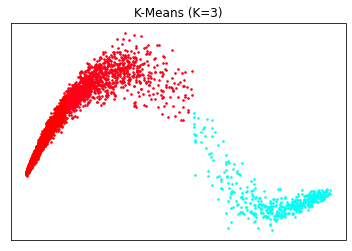

In [41]:
plt.figure(1)

cmap = get_cmap(CLUSTER_NUMBER)

for k in range(CLUSTER_NUMBER):
    cluster_data = vis_labels == k
    plt.scatter(pca_results[cluster_data, 0], pca_results[cluster_data, 1],
                color=cmap(k), marker='.', s=10)

# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=50)
plt.title("K-Means (K={})".format(CLUSTER_NUMBER))
plt.xticks([])
plt.yticks([])
plt.savefig('kmeans.png')
plt.show()

In [42]:
vis_labels = all_label_ids[:10000]

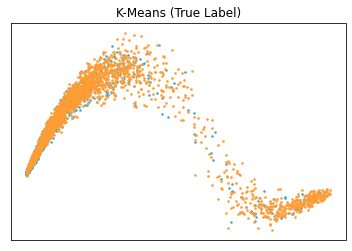

In [43]:
plt.figure(1)

cmap = ['#4EACC5', '#FF9C34', '#4E9A06']

for k in range(3):
    cluster_data = vis_labels == k
    plt.scatter(pca_results[cluster_data, 0], pca_results[cluster_data, 1],
                color=cmap[k], marker='.', s=10)

# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=50)
plt.title("K-Means (True Label)")
plt.xticks([])
plt.yticks([])
plt.savefig('ture_label.png')
plt.show()

In [44]:
# merge json
# train_json = json.load(open('clusters/cluster_mnli_k3_train.json'))
# dev_m_json = json.load(open('clusters/cluster_mnli_k3_dev_matched.json'))
# dev_mm_json = json.load(open('clusters/cluster_mnli_k3_dev_mismatched.json'))

# print(len(train_json))
# print(len(dev_m_json))
# print(len(dev_mm_json))

In [45]:
# with open('clusters/cluster_mnli_k{}.json'.format(CLUSTER_NUMBER), 'w') as fp:
#     json.dump({**train_json, **dev_m_json, **dev_mm_json}, fp)